# All predictive models for 3 month lapse

## Set up

In [1]:
##Import functions

import autograd.numpy as np
from autograd import grad 
import matplotlib.pyplot as plt
%matplotlib inline
import boto3
import pandas as pd

##Import sklearn models & metrics

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression,RidgeClassifierCV, LassoCV, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score, plot_roc_curve, roc_curve, RocCurveDisplay, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif, SelectFromModel
from sklearn.svm import SVR    
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline



In [3]:
## Data cleaning

df = df1.copy(deep=False)

var_details = pd.read_csv('var_details.csv')
vars_cat = var_details.loc[(var_details.VarType=="categorical") & (var_details.Drop=="No")]
vars_cat = vars_cat['Variable'].dropna()
df = df.drop(['RMUSIC', 'RPHOTO', 'RVIDDVD'], axis = 1)
df_cols = df.columns
vars_cat = [x for x in vars_cat if x in df_cols]
df = pd.get_dummies(df, columns = vars_cat)
df['Voluntary.Disenrollment'] = np.where((df['Voluntary.Disenrollment'] != "No "),1, 0)
df = df.loc[((df['Voluntary.Disenrollment'] == 0) & (df.elapsedMonths>12)) | (df['Voluntary.Disenrollment']==1)]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49710 entries, 0 to 56065
Columns: 1740 entries, C210MAH to EarlyLapser
dtypes: float64(195), int64(2), uint8(1543)
memory usage: 148.2 MB
None
0.0    41411
1.0     8299
Name: EarlyLapser, dtype: int64
1    35493
0    14217
Name: Lapsed, dtype: int64
1    45401
0     4309
Name: Voluntary.Disenrollment, dtype: int64


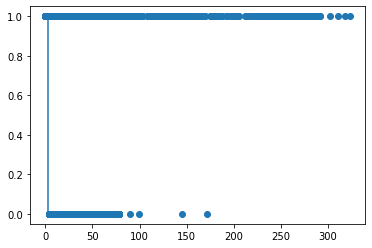

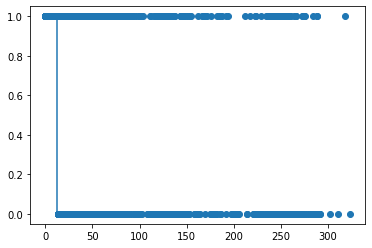

In [4]:
## Create & summarize 3 month lapse model

df = df.loc[((df.Lapsed==0) & (df.elapsedMonths>3))| (df.Lapsed==1)]
df.loc[df.elapsedMonths<=3, ('EarlyLapser')] = 1
df.loc[df.elapsedMonths>3, ('EarlyLapser')] = 0

print(df.info())
print(df['EarlyLapser'].value_counts())
print(df['Lapsed'].value_counts())
print(df['Voluntary.Disenrollment'].value_counts())

plt.scatter(df['elapsedMonths'], df['Lapsed'])
plt.vlines(x=3, ymin=0, ymax=1)
plt.show()

plt.scatter(df['elapsedMonths'], df['Voluntary.Disenrollment'])
plt.vlines(x=12, ymin=0, ymax=1)
plt.show()

In [5]:
##Define functions for evaluation and classification

def categorical_evaluation(y_test, y_pred):
    
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    print("AUC:", round(roc_auc, 2))
    print("ROC Curve: ")
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Model')
    display.plot()  
    plt.show()
    print("F1 Score: {}", round(f1_score(y_test, y_pred), 4))
    print("All Model Metrics: \n", classification_report(y_test, y_pred))
    print("Model Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    return None
   
def classify(y, x):
    conditions = [(y>x),
             (y<=x)]
    values = [1, 0]
    y = np.select(conditions, values)
    return y

def continuous_evaluation(y_test, y_pred):
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    print("AUC:", round(roc_auc, 2))
    print("ROC Curve: ")
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Model')
    display.plot()  
    plt.show()

    thresh = np.linspace(0,1,101)
    f1_scores = []
    for i in range(len(thresh)):
        f1_scores.append(f1_score(y_test, classify(y_pred, thresh[i])))
         
    max_index = f1_scores.index(max(f1_scores))
    thresholdOpt = thresh[max_index]   
    print('Best Threshold: {}'.format(thresholdOpt))
    print("F1 Score: ", f1_score(y_test, classify(y_pred, thresholdOpt)))        
    print("All Model Metrics: \n", classification_report(y_test, classify(y_pred, thresholdOpt)))
    print("Model Confusion Matrix: \n", confusion_matrix(y_test, classify(y_pred, thresholdOpt)))
    
    return None



In [6]:
##Create testing and training data sets


y = df['EarlyLapser']
x = df.drop(['EarlyLapser', 'elapsedMonths', 'Lapsed', 'Voluntary.Disenrollment'], axis = 1)

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(x)
x = imp_median.transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Test models using all variables

## Linear Regressions

AUC: 0.84
ROC Curve: 


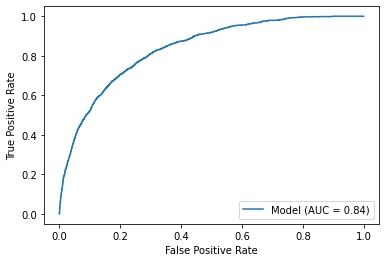

Best Threshold: 0.31
F1 Score:  0.5307232191408374
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.91      0.87      0.89      8293
         1.0       0.48      0.59      0.53      1649

    accuracy                           0.83      9942
   macro avg       0.70      0.73      0.71      9942
weighted avg       0.84      0.83      0.83      9942

Model Confusion Matrix: 
 [[7240 1053]
 [ 673  976]]
CPU times: user 34 s, sys: 2.56 s, total: 36.5 s
Wall time: 37.4 s


In [7]:
%%time
##Linear Regression Model

model = make_pipeline(StandardScaler(), LinearRegression(normalize = True)).fit(x_train, y_train)
y_pred_1 = model.predict(np.array(x_test))

continuous_evaluation(y_test, y_pred_1)


AUC: 0.78
ROC Curve: 


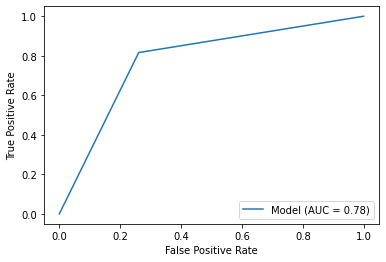

F1 Score: {} 0.5218
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.95      0.74      0.83      8293
         1.0       0.38      0.82      0.52      1649

    accuracy                           0.75      9942
   macro avg       0.67      0.78      0.68      9942
weighted avg       0.86      0.75      0.78      9942

Model Confusion Matrix: 
 [[6129 2164]
 [ 303 1346]]
CPU times: user 2min 8s, sys: 31.7 s, total: 2min 40s
Wall time: 3min 1s


In [8]:
%%time
##Linear Regression Model w/ Ridge regularizer

modelridge = make_pipeline(StandardScaler(), RidgeClassifierCV(scoring = 'f1', class_weight = 'balanced', normalize = True, cv = 5)).fit(x_train, y_train)
y_pred_2 = modelridge.predict(np.array(x_test))

categorical_evaluation(y_test, y_pred_2)

AUC: 0.85
ROC Curve: 


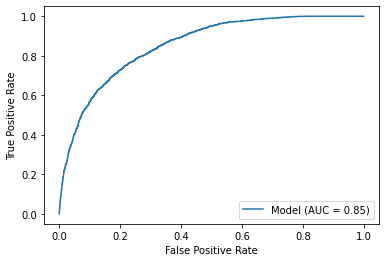

Best Threshold: 0.29
F1 Score:  0.5522875816993464
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      8293
         1.0       0.50      0.61      0.55      1649

    accuracy                           0.83      9942
   macro avg       0.71      0.75      0.73      9942
weighted avg       0.85      0.83      0.84      9942

Model Confusion Matrix: 
 [[7284 1009]
 [ 635 1014]]
CPU times: user 3min, sys: 17.6 s, total: 3min 17s
Wall time: 3min 34s


In [9]:
%%time
##Linear Regression Model w/ Lasso regularizer

modellasso = LassoCV(max_iter = 10000, selection = "random").fit(x_train, y_train)
y_pred_3 = modellasso.predict(np.array(x_test))

continuous_evaluation(y_test, y_pred_3)


## Logistic Regression

AUC: 0.78
ROC Curve: 


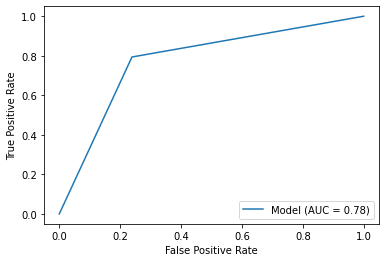

F1 Score: {} 0.5302
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.95      0.76      0.84      8293
         1.0       0.40      0.79      0.53      1649

    accuracy                           0.77      9942
   macro avg       0.67      0.78      0.69      9942
weighted avg       0.86      0.77      0.79      9942

Model Confusion Matrix: 
 [[6313 1980]
 [ 340 1309]]
CPU times: user 1min 51s, sys: 5.48 s, total: 1min 57s
Wall time: 2min 24s


In [10]:
%%time
##Logistic Regression Model w/ stochastic gradient descent

clf = make_pipeline(StandardScaler(), SGDClassifier(loss = 'log', warm_start = True, learning_rate = 'adaptive', eta0 = 0.1, max_iter = 10000, penalty = 'elasticnet', class_weight = 'balanced')).fit(x_train, y_train)
y_pred_4 = clf.predict(np.array(x_test))

categorical_evaluation(y_test, y_pred_4)


## Naive Bayes

AUC: 0.64
ROC Curve: 


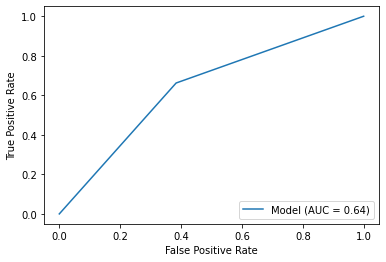

F1 Score: {} 0.3687
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.90      0.62      0.73      8293
         1.0       0.26      0.66      0.37      1649

    accuracy                           0.62      9942
   macro avg       0.58      0.64      0.55      9942
weighted avg       0.79      0.62      0.67      9942

Model Confusion Matrix: 
 [[5110 3183]
 [ 557 1092]]
CPU times: user 1.09 s, sys: 1.05 s, total: 2.14 s
Wall time: 2.96 s


In [11]:
%%time
##Naive-Bayes Model w/ Multinomial classifier

naivebayes = MultinomialNB().fit(x_train, y_train)
y_pred_5 = naivebayes.predict(np.array(x_test))

categorical_evaluation(y_test, y_pred_5)


AUC: 0.7
ROC Curve: 


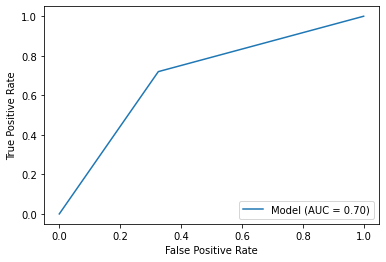

F1 Score: {} 0.429
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.92      0.67      0.78      8293
         1.0       0.31      0.72      0.43      1649

    accuracy                           0.68      9942
   macro avg       0.61      0.70      0.60      9942
weighted avg       0.82      0.68      0.72      9942

Model Confusion Matrix: 
 [[5595 2698]
 [ 462 1187]]


In [12]:
##Naive-Bayes Model w/ Gaussian classifier


naivebayes = GaussianNB().fit(x_train, y_train)
y_pred_6 = naivebayes.predict(np.array(x_test))

categorical_evaluation(y_test, y_pred_6)



## Decision Tree

AUC: 0.68
ROC Curve: 


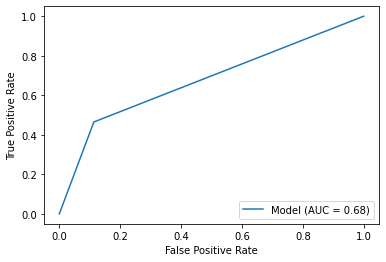

F1 Score: {} 0.457
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.89      0.89      0.89      8293
         1.0       0.45      0.47      0.46      1649

    accuracy                           0.82      9942
   macro avg       0.67      0.68      0.67      9942
weighted avg       0.82      0.82      0.82      9942

Model Confusion Matrix: 
 [[7352  941]
 [ 882  767]]
CPU times: user 21.9 s, sys: 2.53 s, total: 24.4 s
Wall time: 28.7 s


In [13]:
%%time
##Decision Tree Model

decisiontree = make_pipeline(StandardScaler(), DecisionTreeClassifier(class_weight = "balanced", criterion = "entropy", splitter = "random")).fit(x_train, y_train)
y_pred_7 = decisiontree.predict(np.array(x_test))

categorical_evaluation(y_test, y_pred_7)

## Random Forest

AUC: 0.57
ROC Curve: 


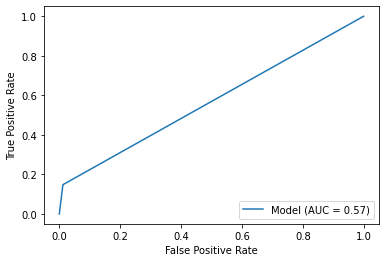

F1 Score: {} 0.245
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.85      0.99      0.92      8293
         1.0       0.71      0.15      0.24      1649

    accuracy                           0.85      9942
   macro avg       0.78      0.57      0.58      9942
weighted avg       0.83      0.85      0.80      9942

Model Confusion Matrix: 
 [[8194   99]
 [1405  244]]
CPU times: user 53.8 s, sys: 3.72 s, total: 57.5 s
Wall time: 2min 3s


In [14]:
%%time
##Random Forest Classifier Model

randomforest = make_pipeline(StandardScaler(), RandomForestClassifier(class_weight = 'balanced')).fit(x_train, y_train)
y_pred_8 = randomforest.predict(np.array(x_test))

categorical_evaluation(y_test, y_pred_8)


AUC: 0.73
ROC Curve: 


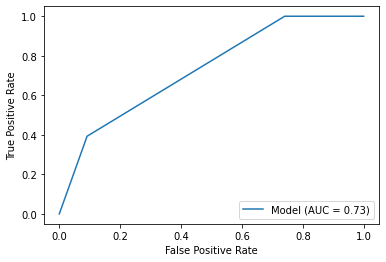

Best Threshold: 0.17
F1 Score:  0.42436149312377214
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.88      0.91      0.90      8293
         1.0       0.46      0.39      0.42      1649

    accuracy                           0.82      9942
   macro avg       0.67      0.65      0.66      9942
weighted avg       0.81      0.82      0.82      9942

Model Confusion Matrix: 
 [[7536  757]
 [1001  648]]
CPU times: user 4min 11s, sys: 7.09 s, total: 4min 18s
Wall time: 5min 4s


In [15]:
%%time

##Random Forest Regressor Model

randomforest = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=2, random_state=0)).fit(x_train, y_train)
y_pred_9 = randomforest.predict(np.array(x_test))

continuous_evaluation(y_test, y_pred_9)


## K-Nearest Neighbours

AUC: 0.59
ROC Curve: 


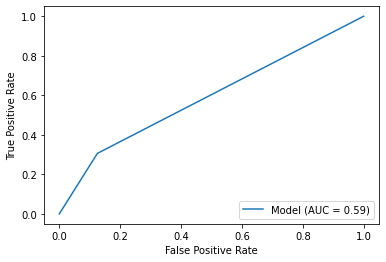

F1 Score: {} 0.3164
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.86      0.87      0.87      8293
         1.0       0.33      0.31      0.32      1649

    accuracy                           0.78      9942
   macro avg       0.60      0.59      0.59      9942
weighted avg       0.77      0.78      0.78      9942

Model Confusion Matrix: 
 [[7255 1038]
 [1144  505]]
CPU times: user 1min 11s, sys: 6.07 s, total: 1min 17s
Wall time: 51 s


In [16]:
%%time
##K-Nearest Neighbours Model

neigh = KNeighborsClassifier(n_neighbors=1).fit(x_train, y_train)
y_pred_10 = neigh.predict(np.array(x_test))

categorical_evaluation(y_test, y_pred_10)

## Neural Network

AUC: 0.5
ROC Curve: 


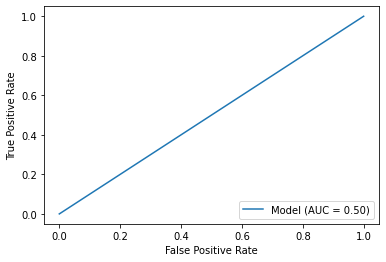

F1 Score: {} 0.0
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.83      1.00      0.91      8293
         1.0       0.00      0.00      0.00      1649

    accuracy                           0.83      9942
   macro avg       0.42      0.50      0.45      9942
weighted avg       0.70      0.83      0.76      9942

Model Confusion Matrix: 
 [[8293    0]
 [1649    0]]
CPU times: user 3min 39s, sys: 17 s, total: 3min 56s
Wall time: 3min 11s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [17]:
%%time

##Neural Network MLP Classifier

clf = MLPClassifier(random_state=1, max_iter=1000).fit(x_train, y_train)
y_pred_11 = clf.predict(x_test)

categorical_evaluation(y_test, y_pred_11)


# Extract most relevant features

In [18]:
%%time    

f1_scores = []
features_num = []

for i in range(len(x_train[0])):
    
    selector = SelectKBest(chi2, k=i+1).fit(x_train, y_train)
    x_train_new = selector.transform(x_train)
    x_test_new = selector.transform(x_test)
    clf = make_pipeline(StandardScaler(), SGDClassifier(loss = 'log', warm_start = True, learning_rate = 'adaptive', eta0 = 0.1, max_iter = 10000, penalty = 'elasticnet', class_weight = 'balanced')).fit(x_train_new, y_train)
    y_pred = clf.predict(np.array(x_test_new))
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    features_num.append(i+1)

max_index = f1_scores.index(max(f1_scores))
best_num = features_num[max_index]
print(best_num, max(f1_scores))
plt.plot(features_num, f1_scores)
plt.vlines(x=best_num, ymin = 0, ymax = 1)
plt.show()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [19]:
%%time

selector = SelectKBest(chi2, k=best_num).fit(x_train, y_train)
x_train_new = selector.transform(x_train)
x_test_new = selector.transform(x_test)

##Logistic Regression Model w/ stochastic gradient descent

clf = make_pipeline(StandardScaler(), SGDClassifier(loss = 'log', warm_start = True, learning_rate = 'adaptive', eta0 = 0.1, max_iter = 10000, penalty = 'elasticnet', class_weight = 'balanced')).fit(x_train_new, y_train)
y_pred = clf.predict(np.array(x_test_new))

categorical_evaluation(y_test, y_pred)


# Resample to balance class distribution

In [20]:
%%time
##Oversample class 0

x_train= pd.DataFrame(x_train)

training = pd.concat([x_train, y_train], axis = 1)

success = training[training.EarlyLapser==1]
failure = training[training.EarlyLapser==0]


success_upsampled = resample(success,
                          replace=True, # sample with replacement
                          n_samples=len(failure), # match number in majority class
                          random_state=27) # reproducible results

upsampled = pd.concat([failure, success_upsampled])

##Split into x and y

y_train_upsampled = upsampled['EarlyLapser']
x_train_upsampled = upsampled.drop('EarlyLapser', axis=1)


##Undersample class 1

failure_downsampled = resample(failure,
                                replace = False, # sample without replacement
                                n_samples = len(success), # match minority n
                                random_state = 27) # reproducible results

downsampled = pd.concat([failure_downsampled, success])

##Split into x and y

y_train_downsampled = downsampled['EarlyLapser']
x_train_downsampled = downsampled.drop('EarlyLapser', axis=1)

x_train_upsampled = imp_median.transform(x_train_upsampled)
x_train_downsampled = imp_median.transform(x_train_downsampled)


CPU times: user 8.79 s, sys: 9.29 s, total: 18.1 s
Wall time: 27.1 s


# Re-run higher performing models

## Logistic Regression Model w/ upsampled data

AUC: 0.51
ROC Curve: 


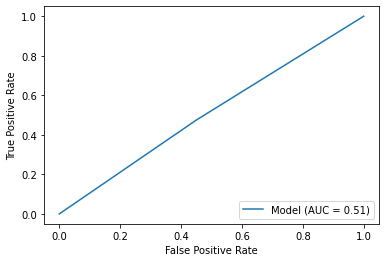

F1 Score: {} 0.2539
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.84      0.55      0.67      8293
         1.0       0.17      0.47      0.25      1649

    accuracy                           0.54      9942
   macro avg       0.51      0.51      0.46      9942
weighted avg       0.73      0.54      0.60      9942

Model Confusion Matrix: 
 [[4564 3729]
 [ 867  782]]
CPU times: user 2min 35s, sys: 8.02 s, total: 2min 43s
Wall time: 3min 22s


In [21]:
%%time

clf = make_pipeline(StandardScaler(), SGDClassifier(loss = 'log', warm_start = True, learning_rate = 'adaptive', eta0 = 0.1, max_iter = 10000, penalty = 'elasticnet')).fit(x_train_upsampled, y_train_upsampled)
y_pred_12 = clf.predict(np.array(x_test))

categorical_evaluation(y_test, y_pred_12)



## Logistic Regression Model w/ downsampled data

AUC: 0.49
ROC Curve: 


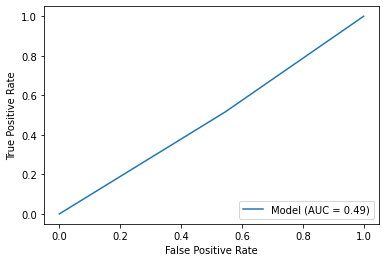

F1 Score: {} 0.2423
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.83      0.46      0.59      8293
         1.0       0.16      0.52      0.24      1649

    accuracy                           0.47      9942
   macro avg       0.49      0.49      0.41      9942
weighted avg       0.71      0.47      0.53      9942

Model Confusion Matrix: 
 [[3776 4517]
 [ 799  850]]
CPU times: user 26.2 s, sys: 937 ms, total: 27.2 s
Wall time: 30.2 s


In [22]:
%%time

clf = make_pipeline(StandardScaler(), SGDClassifier(loss = 'log', warm_start = True, learning_rate = 'adaptive', eta0 = 0.1, max_iter = 10000, penalty = 'elasticnet')).fit(x_train_downsampled, y_train_downsampled)
y_pred_13 = clf.predict(np.array(x_test))

categorical_evaluation(y_test, y_pred_13)

